In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_469543/401849583.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#open files
file = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NumuSelection_Modern_Uboone_Lite.root")
file2 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Numu_Lite.root")
file3 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Nu_Osc_Lite.root") 
file4 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Intrinsic_Nue_Lite.root")

In [3]:
#grab the "protons on target" measurement for each dataset
pot = file["totpot"].member("fElements")[0] 
pot2 = file2["totpot"].member("fElements")[0]
pot3 = file3["totpot"].member("fElements")[0]
pot4 = file4["totpot"].member("fElements")[0]

#unpack each file and grab the relevant variables
Numu_cc = file["tree_numu_cc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Numu_nc = file["tree_numu_nc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Numu = file2["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_NuOsc = file3["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Intrinsic = file4["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")

# doing our "final" weight calculation:
# weights = desired POT * simulated_weights / simulated_POT
des_pot = 1.2e+21
# using 1.2e21 as our desired POT as the ~total beam collected over microboone's lifetime
Numu_cc["pot_weight"] = Numu_cc["weight"] * (des_pot / pot)
Numu_nc["pot_weight"] = Numu_nc["weight"] * (des_pot / pot)
Nue_Numu["pot_weight"] = Nue_Numu["weight"] * (des_pot / pot2)
Nue_NuOsc["pot_weight"] = Nue_NuOsc["weight"] * (des_pot / pot3)
Nue_Intrinsic["pot_weight"] = Nue_Intrinsic["weight"] * (des_pot / pot4)


In [4]:
#split datasets into neutrino types
cc_mu = Numu_cc[(Numu_cc["nu_pdg"] == 14.0)]
cc_mua = Numu_cc[(Numu_cc["nu_pdg"] == -14.0)]
nc_mu = Numu_nc[(Numu_nc["nu_pdg"] == 14.0)]
nc_mua = Numu_nc[(Numu_nc["nu_pdg"] == -14.0)]
osc_e = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == 12.0)]
osc_ea = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == -12.0)]
intrin_e = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == 12.0)]
intrin_ea = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == -12.0)]

In [5]:
# muon to electron neutrino oscillation
#survival probability is 1 - prob_energy
def prob_energy(sin2, deltm, L_E):
    #sin2 = (sin(2*theta))**2
    probab = (sin2 * (np.sin(1.27*deltm*L_E))**2)
    return(probab)


sin2_mumu = 0.1
sin2_ee = 0.1
sin2_mue = 0.003
a = np.arcsin(np.sqrt(0.1))/2
b = np.arcsin(np.sqrt(0.003))/2

deltms = [0.1, 1.2, 2.7, 10]

In [6]:
#if the expected count is 0, the sum goes to infinity, so just skip those boxes for right now
def chi2(expect, obs, distribution="poisson", dof_normalize=False, subtract_from_dof=0):
    if (np.isin(expect,0).any()):
        print("The expected freqency has a bin with 0 entries")
        return
    
    diff = expect - obs
    diff2 = diff**2
    
    if (distribution=="poisson"):
        diff3 = diff2/expect
        
    #elif (_______):
        # change the sigma/uncertainty based off of different expected distributions and fits
        # maybe also change the expected values? but that's less certain as the expected is currently just the intrinsic counts
        #   
        
    chi2 =0
    n = 0
    for i in diff3:
        n = n+1
        if (np.isinf(i)):
            continue
        chi2 = chi2 + i

    if(dof_normalize):
        dof = n - subtract_from_dof
        chi2 = chi2/dof
        print("chi2 per dof (" + str(dof) +"): "+str(chi2))
        return chi2
    else:
        print("total chi2: " + str(chi2))
        return chi2


In [7]:
#make a function that takes in oscillation parameters and the intrinsic and oscilation data and spits out the chi2 value
#def osc_chi2(deltam2, thetaee, thetamue, intrin_data, osc_data, n=1):

#unosc_intriniscnue_mc and fullosc_mc
def osc_chi2(params, unosc_intrinsic_nue_mc, fullosc_mc, n=1):
    deltam2, sin2ee, sin2mue = params
    nue_survival_probs = (1 - prob_energy(sin2ee, deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"]))
    nue_appearance_probs = prob_energy(sin2mue, deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"])
    
    nue_survival_weight = unosc_intrinsic_nue_mc["pot_weight"] * nue_survival_probs
    nue_appearance_weight = fullosc_mc["pot_weight"] * nue_appearance_probs
    
    binnum = 20
    nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
    print(nue_intrinsic)
    print(nue_intrinsic[0])
    print(nue_intrinsic[0].min())
    print(binnum)
    plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", label=["intrin dis","osc"], weights=[nue_survival_weight,nue_appearance_weight])
    plt.show()
    while (nue_intrinsic[0].min() < 2):
        plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", label=["intrin dis","osc"], weights=[nue_survival_weight,nue_appearance_weight])
        plt.show()
        print(nue_intrinsic[1])
        #print(nue_intrinsic[0].min())
        #print(binnum)
        #binnum = binnum-1
        #nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=binnum, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
        
    print(nue_intrinsic[0])
    print(nue_intrinsic[0].min())
    print(binnum)
    
    nue_survival = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_survival_weight) #intrinsic nue with oscillation disappearance
    nue_appearance = np.histogram(fullosc_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_appearance_weight) #oscilated numu->nue
    
    
    chi2_val = chi2(nue_intrinsic[0], nue_survival[0]+nue_appearance[0], dof_normalize=False, subtract_from_dof=2)
    
    #to use in minimize functions to find parameters with specific chi2 values
    # specify here what value to subtract off (the chi2 value you're targeting
    wanted_value = 0
    
    if (chi2_val > 5):
    #plt.subplot(sin2s_mue.shape[0], deltam2s.shape[0],n)
        plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", label=["intrin dis","osc"], weights=[nue_survival_weight,nue_appearance_weight])
        plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="black", histtype="step", label="intrin", weights=unosc_intrinsic_nue_mc["pot_weight"])
        plt.legend()
        plt.ylabel("Events")
        plt.xlabel("Energy {GeV}")
        plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2=$" + str(deltam2) + " and $sin^2(2\\theta_{mue})=$" + str(sin2mue) + " and $sin^2(2\\theta_{ee})=$" + str(sin2ee) + "\n$\\chi^2=$" + str(round(chi2_val,5)))
        plt.show()
    
    return (chi2_val-wanted_value)

In [8]:
#new version
#make a function that takes in oscillation parameters and the intrinsic and oscilation data and spits out the chi2 value
#def osc_chi2(deltam2, thetaee, thetamue, intrin_data, osc_data, n=1):

variable_bins = np.array([0.16, 0.46, 0.76, 1.06, 1.36, 1.66, 1.96, 2.26, 2.56, 2.86, 3.16, 3.46, 3.76, 4.06, 6.00])
bins_widths = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.94])
bin_centers = np.array([0.31, 0.61, 0.91, 1.21, 1.51, 1.81, 2.11, 2.41, 2.71, 3.01, 3.31, 3.61, 3.91, 5.03])

#unosc_intriniscnue_mc and fullosc_mc
def osc_chi2(params, unosc_intrinsic_nue_mc, fullosc_mc, n=1):
    deltam2, sin2ee, sin2mue = params
    nue_survival_probs = (1 - prob_energy(sin2ee, deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"]))
    nue_appearance_probs = prob_energy(sin2mue, deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"])
    
    nue_survival_weight = unosc_intrinsic_nue_mc["pot_weight"] * nue_survival_probs
    nue_appearance_weight = fullosc_mc["pot_weight"] * nue_appearance_probs
    
    nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
    #plt.stairs(nue_intrinsic[0]/bins_widths, nue_intrinsic[1])
    #plt.show()
       
    nue_survival = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_survival_weight) #intrinsic nue with oscillation disappearance
    nue_appearance = np.histogram(fullosc_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_appearance_weight) #oscilated numu->nue
    
    chi2_val = chi2(nue_intrinsic[0], nue_survival[0]+nue_appearance[0], dof_normalize=False, subtract_from_dof=2)
    
    #to use in minimize functions to find parameters with specific chi2 values
    # specify here what value to subtract off (the chi2 value you're targeting
    wanted_value = 0
    
    #if (chi2_val > 5):
    #plt.subplot(sin2s_mue.shape[0], deltam2s.shape[0],n)
        # plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Intrinsic Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
        # plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
        # plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
        # plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
        # plt.legend()
        # plt.ylabel("Events")
        # plt.xlabel("Energy {GeV}")
        # plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2=$" + str(deltam2) + " and $sin^2(2\\theta_{mue})=$" + str(sin2mue) + " and $sin^2(2\\theta_{ee})=$" + str(sin2ee) + "\n$\\chi^2=$" + str(round(chi2_val,5)))
        # plt.show()
    
    return (chi2_val-wanted_value)

In [9]:
sin2s_mue = np.logspace(np.log10(1e-5),np.log10(0.1),30, base=10)
sin2s_ee = np.arange(0,0.5,0.05)
deltam2s = np.logspace(np.log10(0.1),np.log10(10),30, base=10)

In [10]:
chi2s = np.zeros((deltam2s.shape[0],sin2s_mue.shape[0]))

#just look at nue for now, not ea
# currently, I'm assuming only looking/changing the theta for e->e

#plt.figure(figsize=(20,9*thetas.shape[0]))
#n=1

# hold the survival probability of intrinsic nue = 1, thus sin2s_ee=0
for i in range(deltam2s.shape[0]):
    for j in range(sin2s_mue.shape[0]):
        chi2s[i][j] = osc_chi2((deltam2s[i], 0, sin2s_mue[j]), intrin_e, osc_e)
        print("Event " + str(i) + "-" + str(j) + " completed")
        #n = n+1
        

total chi2: 1.0441182512043822e-07
Event 0-0 completed
total chi2: 1.970660248667697e-07
Event 0-1 completed
total chi2: 3.719408037546502e-07
Event 0-2 completed
total chi2: 7.019980313252492e-07
Event 0-3 completed
total chi2: 1.3249453434762469e-06
Event 0-4 completed
total chi2: 2.5006910060534607e-06
Event 0-5 completed
total chi2: 4.719783754513498e-06
Event 0-6 completed
total chi2: 8.908081260510561e-06
Event 0-7 completed
total chi2: 1.6813039722006896e-05
Event 0-8 completed
total chi2: 3.173279367655581e-05
Event 0-9 completed
total chi2: 5.9892215278625196e-05
Event 0-10 completed
total chi2: 0.00011304007732640917
Event 0-11 completed
total chi2: 0.00021335091751938985
Event 0-12 completed
total chi2: 0.0004026767769711487
Event 0-13 completed
total chi2: 0.0007600088558190589
Event 0-14 completed
total chi2: 0.0014344344992231147
Event 0-15 completed
total chi2: 0.0027073399432222455
Event 0-16 completed
total chi2: 0.005109811268577332
Event 0-17 completed
total chi2: 0.

In [11]:
sinv, deltv = np.meshgrid(sin2s_mue, deltam2s)

Text(0.5, 1.0, '$\\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{mue})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{ee})=0$, or 100% Intrinsic Nue Survival')

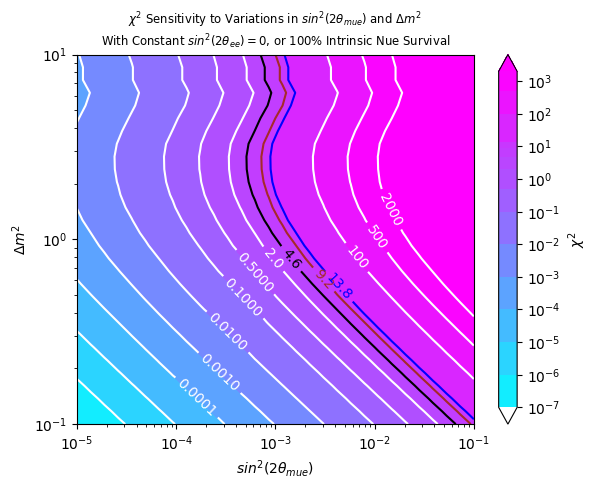

In [12]:
#contour plot has order of x and y switched, so the chi2s array (thetas.shape, deltam2s.shape) needs to be input as plt.contour(deltam2s,thetas,chi2s)
plt.contourf(sin2s_mue,deltam2s, chi2s, norm="log", extend="both", levels=[0.0000001,0.000001,0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5,2,4.6,9.2,13.8,100,500,2000], cmap="cool")#, colors=["red","orange","yellow","green","blue","purple","pink"])
plt.xscale("log")
plt.yscale("log")
cbar = plt.colorbar(label="$\chi^2$")
cbar.set_ticks([0.0000001,0.000001,0.00001, 0.0001,0.001,0.01,0.1,1,10,100,1000])

CL = plt.contour(sin2s_mue,deltam2s, chi2s, norm="log", levels=[0.0001, 0.001, 0.01, 0.1, 0.5], colors=["white","white","white","white","white","white"])
manual_locations = [(0.00009, 0.1), (0.0003, 0.2), (0.0003, 0.3), (0.0005, 0.5), (0.0007, 0.7)]
plt.clabel(CL, inline=True, manual = manual_locations)
CL1 = plt.contour(sin2s_mue,deltam2s, chi2s, norm="log", levels=[100,500,2000], colors=["white","white", "white"])
manual_locations1 = [(0.01,1), (0.009,0.9), (0.03, 1.8)]
plt.clabel(CL1, inline=True, manual = manual_locations1)
CL2 = plt.contour(sin2s_mue,deltam2s, chi2s, norm="log", levels=[2, 4.6,9.2,13.8], colors=["white","black","brown","blue"])
manual_locations2 = [(0.001, 0.8),(0.0015, 0.8),(0.003,0.6),(0.007, 0.7)]
plt.clabel(CL2, inline=True, manual = manual_locations2)
CL3 = plt.contour(sin2s_mue,deltam2s, chi2s, norm="log", levels=[1e-7,1e-6,0.00001], colors="white")
#manual_locations3 = [(0.00001, 0.1), (0.00005, 0.2), (0.00009, 0.3)]
#plt.clabel(CL3, inline=True)#, #manual = manual_locations3)

plt.xlabel("$sin^2(2\\theta_{mue})$")
plt.ylabel("$\\Delta{m}^2$")
plt.title("$\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{mue})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{ee})=0$, or 100% Intrinsic Nue Survival", fontsize="small")

Text(0.5, 1.0, '$\\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{mue})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{ee})=0$, or 100% Intrinsic Nue Survival')

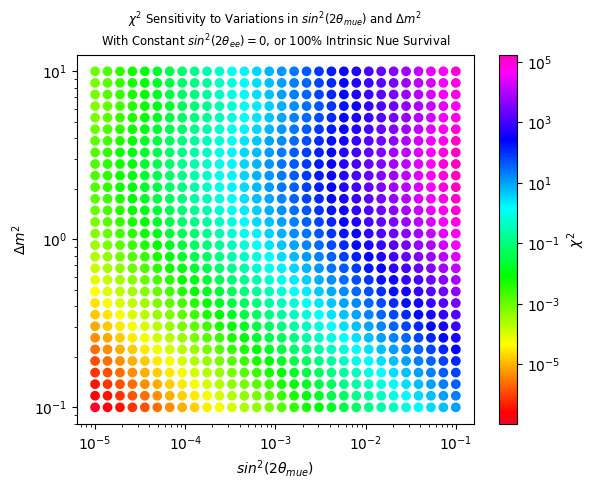

In [13]:
plt.scatter(sinv,deltv, c=chi2s, norm="log", cmap="gist_rainbow")
plt.colorbar(label="$\chi^2$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$sin^2(2\\theta_{mue})$")
plt.ylabel("$\\Delta{m}^2$")
plt.title("$\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{mue})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{ee})=0$, or 100% Intrinsic Nue Survival", fontsize="small")

In [38]:
chi2s2 = np.zeros((deltam2s.shape[0],sin2s_ee.shape[0]))

#just look at nue for now, not ea
# currently, I'm assuming only looking/changing the theta for e->e

#plt.figure(figsize=(20,9*thetas.shape[0]))
#n=1

# hold the nue appearance rate at 0 so we ONLY see the disappearance, thus sin2_mue = 0 as no numu->nue oscillations occur
for i in range(deltam2s.shape[0]):
    for j in range(sin2s_ee.shape[0]):
        chi2s2[i][j] = osc_chi2((deltam2s[i], sin2s_ee[j], 0), intrin_e, osc_e)
        print("Event " + str(i) + "-" + str(j) + " completed")
        #n = n+1
        

total chi2: 0.0
Event 0-0 completed
total chi2: 5.4992932961687524e-05
Event 0-1 completed
total chi2: 0.00021997173181501244
Event 0-2 completed
total chi2: 0.0004949363965579123
Event 0-3 completed
total chi2: 0.0008798869271936324
Event 0-4 completed
total chi2: 0.0013748233237178883
Event 0-5 completed
total chi2: 0.001979745586136837
Event 0-6 completed
total chi2: 0.002694653714444504
Event 0-7 completed
total chi2: 0.003519547708650969
Event 0-8 completed
total chi2: 0.004454427568737176
Event 0-9 completed
total chi2: 0.0
Event 1-0 completed
total chi2: 0.0020478954343766315
Event 1-1 completed
total chi2: 0.008191581737300587
Event 1-2 completed
total chi2: 0.018431058908778494
Event 1-3 completed
total chi2: 0.03276632694878843
Event 1-4 completed
total chi2: 0.0511973858573675
Event 1-5 completed
total chi2: 0.07372423563444454
Event 1-6 completed
total chi2: 0.10034687628014445
Event 1-7 completed
total chi2: 0.13106530779436626
Event 1-8 completed
total chi2: 0.16587953017

In [39]:
sinv2, deltv2 = np.meshgrid(sin2s_ee, deltam2s)

Text(0.5, 1.0, '$\\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{ee})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{mue})=0$, or 0% Nue Appearance')

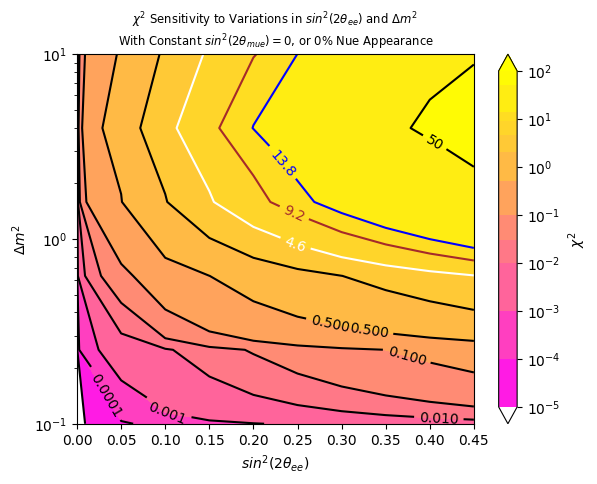

In [40]:
#contour plot has order of x and y switched, so the chi2s array (thetas.shape, deltam2s.shape) needs to be input as plt.contour(deltam2s,thetas,chi2s)
plt.contourf(sin2s_ee,deltam2s,chi2s2,extend="both", norm="log",levels=[0.00001,0.0001,0.001,0.01,0.03,0.1, 0.5,2,4.6,9.2,13.8,50,100], cmap="spring")#, colors=["red","orange","yellow","green","blue","purple","pink"])
plt.yscale("log")
cbar = plt.colorbar(label="$\chi^2$")
cbar.set_ticks([0.00001, 0.0001, 0.001,0.01,0.1,1,10,100])

CL = plt.contour(sin2s_ee,deltam2s, chi2s2, norm="linear", levels=[0.001,0.01, 0.03, 0.1, 0.5,2], colors="black")
manual_locations = [(0.1,0.1),(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
plt.clabel(CL, inline=True, manual = manual_locations)
CL1 = plt.contour(sin2s_ee,deltam2s, chi2s2, norm="log", levels=[50,100], colors="black")
manual_locations1 = [(0.4,3)]
plt.clabel(CL1, inline=True, manual = manual_locations1)
CL2 = plt.contour(sin2s_ee,deltam2s, chi2s2, norm="log", levels=[4.6,9.2,13.8], colors=["white","brown","blue"])
manual_locations2 = [(0.25,1),(0.25, 1.5),(0.25, 3)]
plt.clabel(CL2, inline=True, manual = manual_locations2)
CL3 = plt.contour(sin2s_ee,deltam2s, chi2s2, norm="linear", levels=[0.0001], colors="black")
manual_locations3 = [(0.04, 0.15)]
plt.clabel(CL3, inline=True, manual = manual_locations3)
CL3 = plt.contour(sin2s_ee,deltam2s, chi2s2, norm="linear", levels=[0.00001], colors="black")
manual_locations3 = []
plt.clabel(CL3, inline=True, manual = manual_locations3)

plt.xlabel("$sin^2(2\\theta_{ee})$")
plt.ylabel("$\\Delta{m}^2$")
plt.title("$\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{ee})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{mue})=0$, or 0% Nue Appearance", fontsize="small")

In [17]:
chi2s3 = np.zeros((deltam2s.shape[0],sin2s_ee.shape[0]))

#just look at nue for now, not ea
# currently, I'm assuming only looking/changing the theta for e->e

#plt.figure(figsize=(20,9*thetas.shape[0]))
#n=1

#hold appearance probability small, but nonzero at 0.005
for i in range(deltam2s.shape[0]):
    for j in range(sin2s_ee.shape[0]):
        chi2s3[i][j] = osc_chi2((deltam2s[i], sin2s_ee[j], 0.005), intrin_e, osc_e)
        print("Event " + str(i) + "-" + str(j) + " completed")
        #n = n+1
sinv3, deltv3 = np.meshgrid(sin2s_ee, deltam2s)        

total chi2: 0.026102956280155513
Event 0-0 completed
total chi2: 0.023787636261092135
Event 0-1 completed
total chi2: 0.02158230210743973
Event 0-2 completed
total chi2: 0.01948695381968385
Event 0-3 completed
total chi2: 0.017501591397816617
Event 0-4 completed
total chi2: 0.015626214841843372
Event 0-5 completed
total chi2: 0.013860824151757602
Event 0-6 completed
total chi2: 0.012205419327569857
Event 0-7 completed
total chi2: 0.01066000036924554
Event 0-8 completed
total chi2: 0.009224567276842236
Event 0-9 completed
total chi2: 0.04906753406041612
Event 1-0 completed
total chi2: 0.04471678790938762
Event 1-1 completed
total chi2: 0.04057264548121406
Event 1-2 completed
total chi2: 0.03663510677654296
Event 1-3 completed
total chi2: 0.032904171795352134
Event 1-4 completed
total chi2: 0.02937984053768145
Event 1-5 completed
total chi2: 0.02606211300351751
Event 1-6 completed
total chi2: 0.022950989192827488
Event 1-7 completed
total chi2: 0.020046469105676635
Event 1-8 completed
to

Text(0.5, 1.0, '$\\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{ee})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{mue})=0.005$')

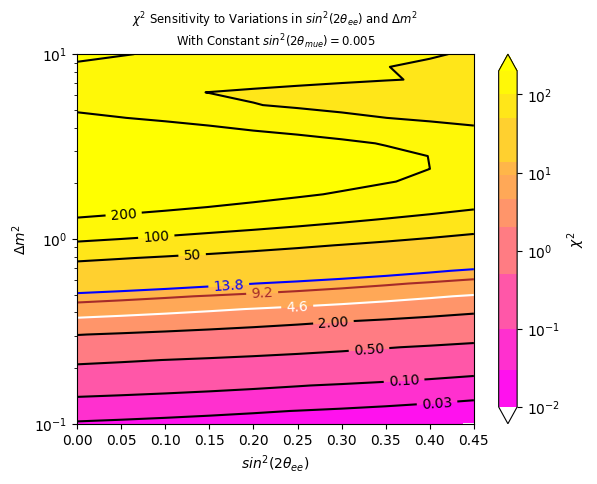

In [18]:
#contour plot has order of x and y switched, so the chi2s array (thetas.shape, deltam2s.shape) needs to be input as plt.contour(deltam2s,thetas,chi2s)
plt.contourf(sin2s_ee,deltam2s,chi2s3,extend="both", norm="log",levels=[0.01,0.03, 0.1, 0.5,2,4.6,9.2,13.8,50,100,200], cmap="spring")#, colors=["red","orange","yellow","green","blue","purple","pink"])
plt.yscale("log")
cbar = plt.colorbar(label="$\chi^2$")
cbar.set_ticks([0.01,0.1,1,10,100])

CL = plt.contour(sin2s_ee,deltam2s, chi2s3, norm="linear", levels=[0.03, 0.1, 0.5,2], colors="black")
manual_locations = [(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
plt.clabel(CL, inline=True, manual = manual_locations)
CL1 = plt.contour(sin2s_ee,deltam2s, chi2s3, norm="log", levels=[50,100,200], colors="black")
manual_locations1 = [(0.13,0.9), (0.09,1), (0.05, 2)]
plt.clabel(CL1, inline=True, manual = manual_locations1)
CL2 = plt.contour(sin2s_ee,deltam2s, chi2s3, norm="log", levels=[4.6,9.2,13.8], colors=["white","brown","blue"])
manual_locations2 = [(0.17,0.8),(0.21, 0.5),(0.25, 0.4)]
plt.clabel(CL2, inline=True, manual = manual_locations2)

plt.xlabel("$sin^2(2\\theta_{ee})$")
plt.ylabel("$\\Delta{m}^2$")
plt.title("$\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{ee})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{mue})=0.005$", fontsize="small")

In [9]:
sin2s_mue = np.logspace(np.log10(1e-5),np.log10(0.1),30, base=10)
sin2s_ee = np.arange(0,0.5,0.05)
deltam2s = np.logspace(np.log10(0.1),np.log10(10),30, base=10)

In [10]:
#try a 3D plot
chi2s3d = np.zeros((deltam2s.shape[0],sin2s_ee.shape[0], sin2s_mue.shape[0]))

for i in range(deltam2s.shape[0]):
    for j in range(sin2s_ee.shape[0]):
        for k in range(sin2s_mue.shape[0]):
            chi2s3d[i][j][k] = osc_chi2((deltam2s[i], sin2s_ee[j], sin2s_mue[k]), intrin_e, osc_e)
            print("Event " + str(i) + "-" + str(j) + "-" + str(k) + " completed")
        #n = n+1
      

total chi2: 1.0441182512043822e-07
Event 0-0-0 completed
total chi2: 1.970660248667697e-07
Event 0-0-1 completed
total chi2: 3.719408037546502e-07
Event 0-0-2 completed
total chi2: 7.019980313252492e-07
Event 0-0-3 completed
total chi2: 1.3249453434762469e-06
Event 0-0-4 completed
total chi2: 2.5006910060534607e-06
Event 0-0-5 completed
total chi2: 4.719783754513498e-06
Event 0-0-6 completed
total chi2: 8.908081260510561e-06
Event 0-0-7 completed
total chi2: 1.6813039722006896e-05
Event 0-0-8 completed
total chi2: 3.173279367655581e-05
Event 0-0-9 completed
total chi2: 5.9892215278625196e-05
Event 0-0-10 completed
total chi2: 0.00011304007732640917
Event 0-0-11 completed
total chi2: 0.00021335091751938985
Event 0-0-12 completed
total chi2: 0.0004026767769711487
Event 0-0-13 completed
total chi2: 0.0007600088558190589
Event 0-0-14 completed
total chi2: 0.0014344344992231147
Event 0-0-15 completed
total chi2: 0.0027073399432222455
Event 0-0-16 completed
total chi2: 0.005109811268577332
E

In [11]:
sinmue_3d, sinee_3d, deltm3d = np.meshgrid(sin2s_mue, sin2s_ee, deltam2s)  

Text(0.5, 0.92, '$\\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{mue})$, $sin^2(2\\theta_{ee})$, and $\\Delta{m}_{mue}^2$')

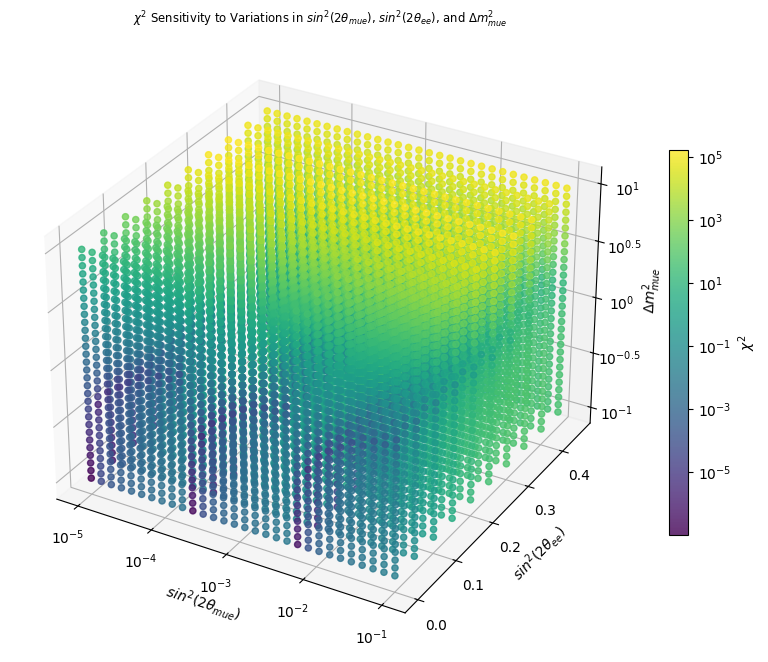

In [12]:
#try plotting a 3d scatterplot with colors=chi2 correspondance (no contours)

#apparantly you can't do a log scale axis in 3d scatterplot, so manually take the log myself, then plot on a linear scale
sinmue_3d_log = np.log10(sinmue_3d)
deltm3d_log = np.log10(deltm3d)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

scattr = ax.scatter3D(sinmue_3d_log, sinee_3d, deltm3d_log, c=chi2s3d, norm="log", alpha=0.8)
ax.set_xlabel("$sin^2(2\\theta_{mue})$")
ax.set_xticks([-5,-4,-3,-2,-1], labels=["$10^{-5}$", "$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$"])
ax.set_ylabel("$sin^2(2\\theta_{ee})$")
ax.set_zlabel("$\Delta{m}^2_{mue}$")
ax.set_zticks([-1,-0.5,0,0.5,1], labels=["$10^{-1}$", "$10^{-0.5}$", "$10^{0}$", "$10^{0.5}$", "$10^{1}$"])

fig.colorbar(scattr, label="$\\chi^2$", shrink=0.5) 
ax.set_title("$\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{mue})$, $sin^2(2\\theta_{ee})$, and $\\Delta{m}_{mue}^2$", fontsize="small")

In [ ]:
# next try making the varying disappearance graphs at multiple constant sin2mue, starting at 0 and then working up
#plot them all side by side in order to see how the chi2-disappearance dependence changes shape at differing appearance values

In [22]:
chi2s3d[:,:,0]

array([[1.04411825e-07, 5.03567189e-05, 2.10594892e-04, 4.80818931e-04,
        8.61028835e-04, 1.35122461e-03, 1.95140624e-03, 2.66157374e-03,
        3.48172711e-03, 4.41186635e-03],
       [3.92677793e-06, 1.87443220e-03, 7.84072850e-03, 1.79028157e-02,
        3.20606937e-02, 5.03143626e-02, 7.26638224e-02, 9.91090730e-02,
        1.29650115e-01, 1.64286947e-01],
       [1.12220472e-04, 5.03653011e-02, 2.10963900e-01, 4.81908017e-01,
        8.63197652e-01, 1.35483281e+00, 1.95681348e+00, 2.66913967e+00,
        3.49181138e+00, 4.42482860e+00],
       [1.14534679e-03, 4.28146339e-01, 1.80078116e+00, 4.11904980e+00,
        7.38295227e+00, 1.15924886e+01, 1.67476587e+01, 2.28484626e+01,
        2.98949004e+01, 3.78869720e+01],
       [1.13406078e-03, 8.15543483e-01, 3.36991935e+00, 7.66426165e+00,
        1.36985704e+01, 2.14728456e+01, 3.09870872e+01, 4.22412953e+01,
        5.52354698e+01, 6.99696107e+01],
       [8.96491487e-04, 5.15267042e-01, 2.13603641e+00, 4.86320458e+00,
   

In [53]:
sin2s_ee = np.arange(0,0.5,0.05)
deltam2s = np.logspace(np.log10(0.1),np.log10(10),30, base=10)

#manually add which constant sin2mue terms to use:
sin2_mue_options = np.array([0,1e-5,1e-4,0.0005,1e-3,0.002,0.005, 1e-2,1e-1])
chi2smult = np.zeros((deltam2s.shape[0],sin2s_ee.shape[0], sin2_mue_options.shape[0]))

for i in range(deltam2s.shape[0]):
    for j in range(sin2s_ee.shape[0]):
        for k in range(sin2_mue_options.shape[0]):
            chi2smult[i][j][k] = osc_chi2((deltam2s[i], sin2s_ee[j], sin2_mue_options[k]), intrin_e, osc_e)
            print("Event " + str(i) + "-" + str(j) + "-" + str(k) + " completed")


total chi2: 0.0
Event 0-0-0 completed
total chi2: 1.0441182512043822e-07
Event 0-0-1 completed
total chi2: 1.0441182512063599e-05
Event 0-0-2 completed
total chi2: 0.0002610295628015634
Event 0-0-3 completed
total chi2: 0.0010441182512062564
Event 0-0-4 completed
total chi2: 0.004176473004824969
Event 0-0-5 completed
total chi2: 0.026102956280155513
Event 0-0-6 completed
total chi2: 0.1044118251206222
Event 0-0-7 completed
total chi2: 10.441182512062358
Event 0-0-8 completed
total chi2: 5.4992932961687524e-05
Event 0-1-0 completed
total chi2: 5.035671888276254e-05
Event 0-1-1 completed
total chi2: 1.8027856433246958e-05
Event 0-1-2 completed
total chi2: 7.899120056074289e-05
Event 0-1-3 completed
total chi2: 0.0006250485937629246
Event 0-1-4 completed
total chi2: 0.0032833407569766242
Event 0-1-5 completed
total chi2: 0.023787636261092135
Event 0-1-6 completed
total chi2: 0.09972619214953375
Event 0-1-7 completed
total chi2: 10.393831245954816
Event 0-1-8 completed
total chi2: 0.000219

In [13]:
# re-create the same 3d plot as a series of contour plots
chi2smult = chi2s3d 
sin2_mue_options = sin2s_mue

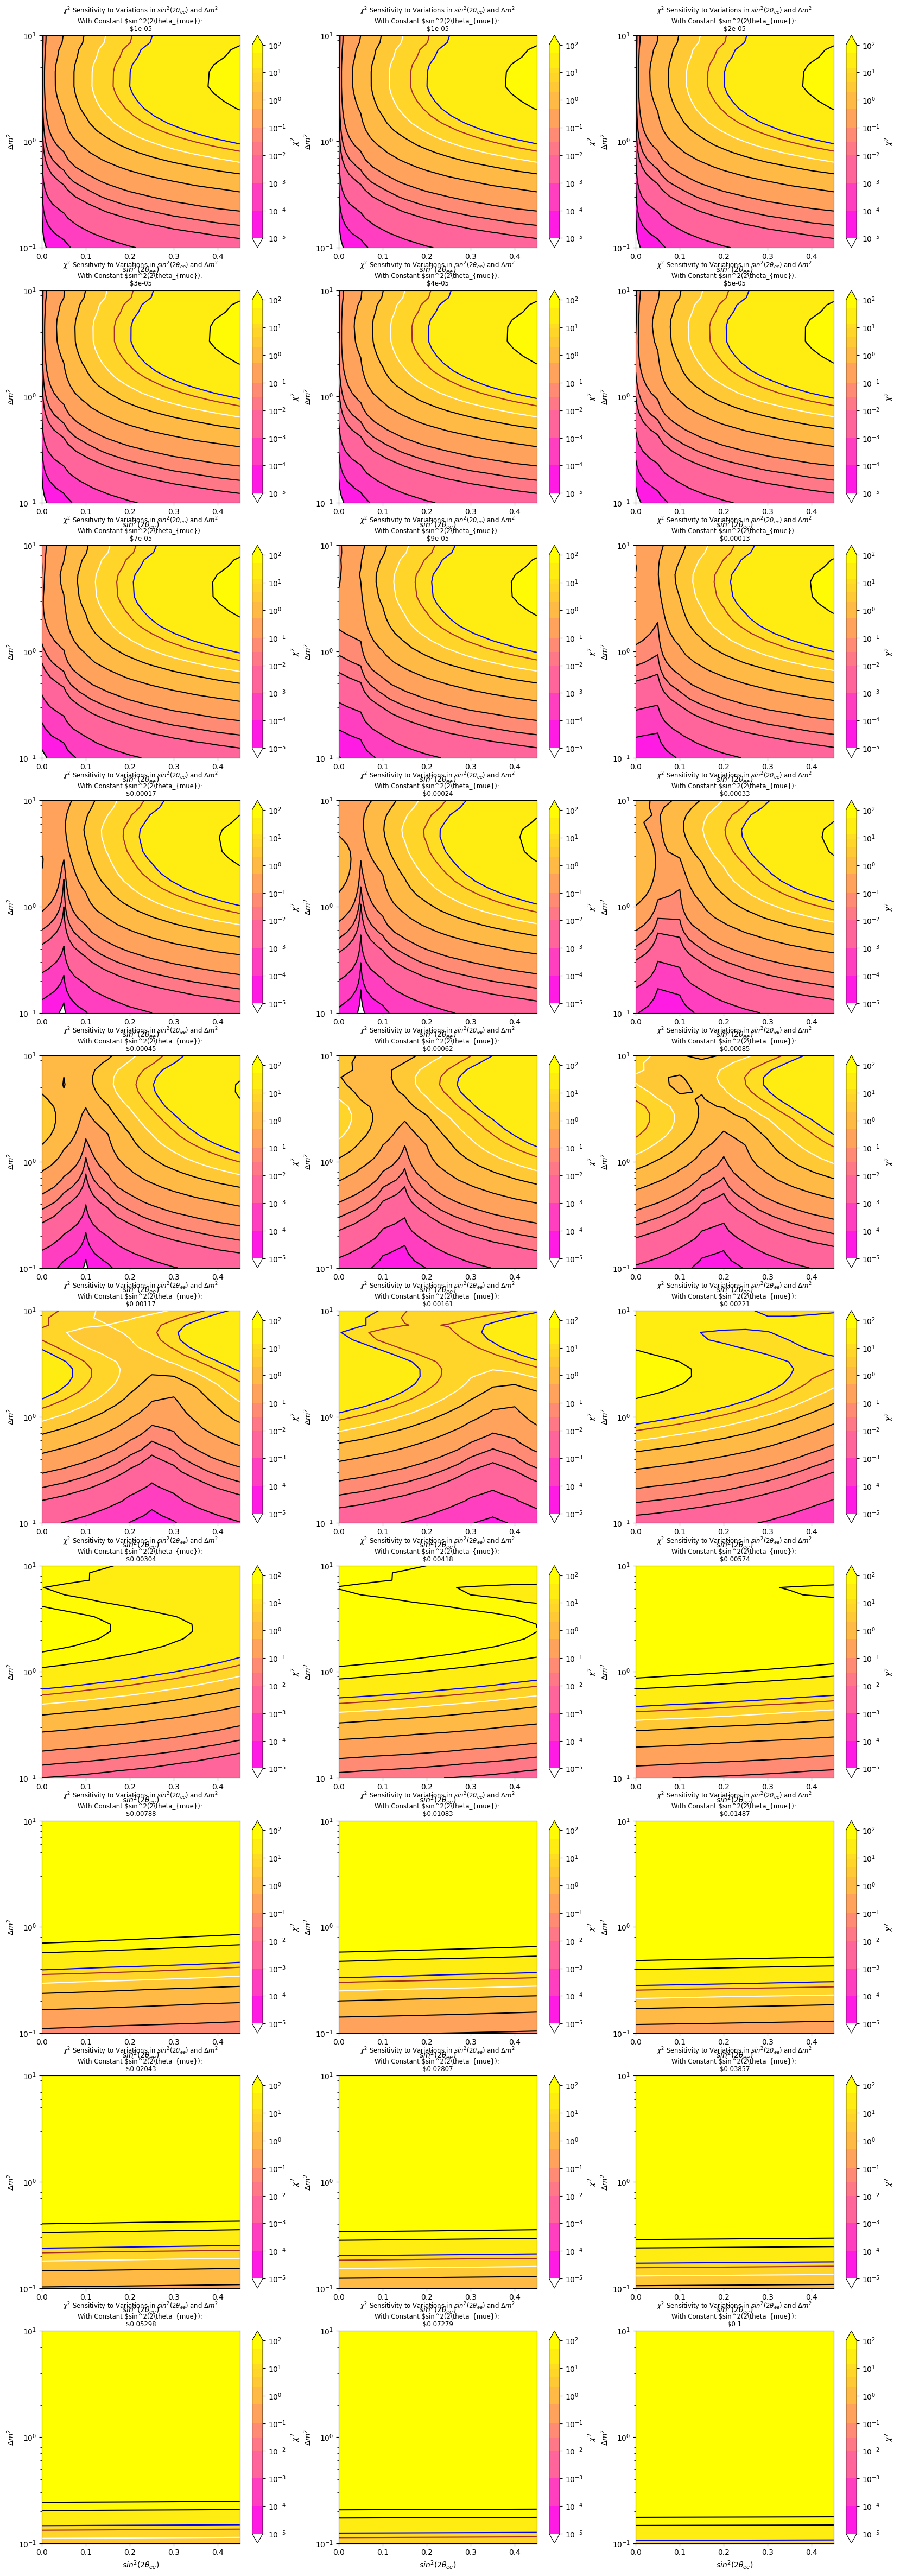

In [58]:
plt.figure(figsize=(20,60))
for i in range(sin2_mue_options.shape[0]):
    
    plt.subplot(10,3,i+1)
    plt.contourf(sin2s_ee,deltam2s,chi2smult[:,:,i],extend="both", norm="log",levels=[0.00001,0.0001,0.001,0.01,0.03,0.1, 0.5,2,4.6,9.2,13.8,50,100], cmap="spring")#, colors=["red","orange","yellow","green","blue","purple","pink"])
    plt.yscale("log")
    cbar = plt.colorbar(label="$\chi^2$")
    cbar.set_ticks([0.00001, 0.0001, 0.001,0.01,0.1,1,10,100])

    CL = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="linear", levels=[0.001,0.01, 0.03, 0.1, 0.5,2], colors="black")
    #manual_locations = [(0.1,0.1),(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
    #plt.clabel(CL, inline=True, manual = manual_locations)
    CL1 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="log", levels=[50,100], colors="black")
    #manual_locations1 = [(0.4,3)]
    #plt.clabel(CL1, inline=True, manual = manual_locations1)
    CL2 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="log", levels=[4.6,9.2,13.8], colors=["white","brown","blue"])
    #manual_locations2 = [(0.25,1),(0.25, 1.5),(0.25, 3)]
    #plt.clabel(CL2, inline=True, manual = manual_locations2)
    CL3 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="linear", levels=[0.0001], colors="black")
    #manual_locations3 = [(0.04, 0.15)]
    #plt.clabel(CL3, inline=True, manual = manual_locations3)
    CL3 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="linear", levels=[0.00001], colors="black")
    #manual_locations3 = []
    #plt.clabel(CL3, inline=True, manual = manual_locations3)
    
    plt.xlabel("$sin^2(2\\theta_{ee})$")
    plt.ylabel("$\\Delta{m}^2$")
    plt.title("$\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{ee})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{mue}): \n$" + str(round(sin2_mue_options[i],5)), fontsize="small")

    
    plt.figure(figsize=(5,5))
    plt.contourf(sin2s_ee,deltam2s,chi2smult[:,:,i],extend="both", norm="log",levels=[0.00001,0.0001,0.001,0.01,0.03,0.1, 0.5,2,4.6,9.2,13.8,50,100], cmap="spring")#, colors=["red","orange","yellow","green","blue","purple","pink"])
    plt.yscale("log")
    cbar = plt.colorbar(label="$\chi^2$")
    cbar.set_ticks([0.00001, 0.0001, 0.001,0.01,0.1,1,10,100])

    CL = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="linear", levels=[0.001,0.01, 0.03, 0.1, 0.5,2], colors="black")
    #manual_locations = [(0.1,0.1),(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
    #plt.clabel(CL, inline=True, manual = manual_locations)
    CL1 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="log", levels=[50,100], colors="black")
    #manual_locations1 = [(0.4,3)]
    #plt.clabel(CL1, inline=True, manual = manual_locations1)
    CL2 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="log", levels=[4.6,9.2,13.8], colors=["white","brown","blue"])
    #manual_locations2 = [(0.25,1),(0.25, 1.5),(0.25, 3)]
    #plt.clabel(CL2, inline=True, manual = manual_locations2)
    CL3 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="linear", levels=[0.0001], colors="black")
    #manual_locations3 = [(0.04, 0.15)]
    #plt.clabel(CL3, inline=True, manual = manual_locations3)
    CL3 = plt.contour(sin2s_ee,deltam2s, chi2smult[:,:,i], norm="linear", levels=[0.00001], colors="black")
    #manual_locations3 = []
    #plt.clabel(CL3, inline=True, manual = manual_locations3)
    
    plt.xlabel("$sin^2(2\\theta_{ee})$")
    plt.ylabel("$\\Delta{m}^2$")
    plt.title("$\chi^2$ Sensitivity to Variations in $sin^2(2\\theta_{ee})$ and $\\Delta{m}^2$ \nWith Constant $sin^2(2\\theta_{mue})$: \n" + str(round(sin2_mue_options[i],5)), fontsize="small")

    name = "figs/fig"+str(i)
    plt.savefig(name, format="png", bbox_inches="tight")
    plt.close()

In [59]:
#combine the 2d contour plots into a single gif

import matplotlib.image as mpim
k = []

for i in range(30):
    name = "figs/fig" + str(i)
    k.append(mpim.imread(name))


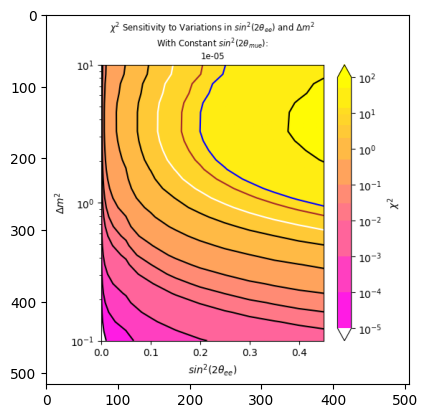

MovieWriter ffmpeg unavailable; using Pillow instead.


In [61]:
import matplotlib.animation as animation

# Create the figure and axes objects
fig, ax = plt.subplots()

# Set the initial image
im = ax.imshow(k[0], animated=True)

def update(i):
    im.set_array(k[i])
    return im, 

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(k), interval=200, blit=True,repeat_delay=10,)

# Show the animation
plt.show()

animation_fig.save("animated_3dplot_vs3.gif")

In [149]:
def function(params,a,b):
    x,y = params
    return a*x**2 - b*y + 2
def funct(x,a,b):
    return a*x**2 + b

optimize.minimize(funct,5,(1,-1), method='L-BFGS-B')

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.9999999999998738
        x: [ 3.553e-07]
      nit: 2
      jac: [ 7.216e-07]
     nfev: 6
     njev: 3
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [187]:
# use optimization to find the parameters that fit best
# also want to find the "boundary" or "limit" parameters that give a chi2 value within 90% CL, aka, with a critical value of chi2 < 4.6 (for 2 dof or 2 parameters)
# so, we just find the parameters that have *exactly* chi2 = 4.6 to act as our outer limits, giving our parameter measurements error bars

from scipy import optimize

optimize.minimize(osc_chi2, (1,0.05),(b,intrin_e, osc_e), method='L-BFGS-B')

chi2 per dof (18): 2.10869959631575
chi2 per dof (18): 2.1086996502193545
chi2 per dof (18): 2.1086995725219695
chi2 per dof (18): 6.154087967680063e-06
chi2 per dof (18): 6.1540908518663995e-06
chi2 per dof (18): 6.1540873191104314e-06
chi2 per dof (18): 6.1392689333368376e-06
chi2 per dof (18): 6.139271812300035e-06
chi2 per dof (18): 6.13926828694549e-06
chi2 per dof (18): 6.080273357908663e-06
chi2 per dof (18): 6.080276215826727e-06
chi2 per dof (18): 6.0802727194794315e-06
chi2 per dof (18): 5.848735237333226e-06
chi2 per dof (18): 5.848738012066351e-06
chi2 per dof (18): 5.848734630488056e-06
chi2 per dof (18): 4.990886499586473e-06
chi2 per dof (18): 4.99088895930553e-06
chi2 per dof (18): 4.990886007047028e-06
chi2 per dof (18): 1.1639495195867056e-06
chi2 per dof (18): 1.1639503426064555e-06
chi2 per dof (18): 1.16394942179459e-06
chi2 per dof (18): 4.2921276663063487e-07
chi2 per dof (18): 4.2921315668331485e-07
chi2 per dof (18): 4.2921272958257737e-07
chi2 per dof (18): 1.

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 4.300507296813579e-08
        x: [ 2.466e-02  4.548e-01]
      nit: 6
      jac: [ 6.975e-06 -4.178e-07]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [152]:
optimize.minimize(osc_chi2, (2,0.05),(b,intrin_e, osc_e), method='L-BFGS-B')

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -4.599999963536414
        x: [ 2.302e-02  3.630e+00]
      nit: 13
      jac: [ 6.306e-06  5.329e-07]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [154]:
optimize.minimize(osc_chi2, (0.1,0.05),(b,intrin_e, osc_e), method='L-BFGS-B')

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -4.599999985180239
        x: [ 7.330e-03  5.113e-02]
      nit: 9
      jac: [ 8.082e-06  0.000e+00]
     nfev: 33
     njev: 11
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>